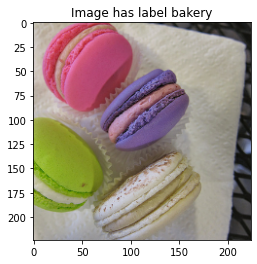

In [1]:
import numpy as np
import tensorflow as tf
from pathlib import Path
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Image settings
im_dir = Path("./imagenet-5k")
im_paths = list(im_dir.glob("*.JPEG"))
desired_imshape = [224, 224]

# Load up the labels
labels = np.array(open(im_dir / "labels.txt").read().splitlines(), dtype=np.int32)
label_texts = open(im_dir / "label_text.txt").read().splitlines()


def get_image_and_label(im_path):
    im_path = str(im_path)

    # Read the image number, then get the appropriate label. The -1 is because labels is 0-indexed
    im_num = int(re.search(r"_(\d+).JPEG", im_path).group(1))
    label = labels[im_num-1]

    # Load up the image and normalize it
    im = tf.io.read_file(im_path)
    im = tf.image.decode_jpeg(im, channels=3)
    im = tf.cast(im, tf.float32)
    im /= 255.0

    # Determine whether this image is landscape or portrait
    landscape = im.shape[1] - im.shape[0] > 0
    
    # Crop the center part of the image and resize to 224x224
    if landscape:
        nonsquareness = im.shape[1] - im.shape[0]
        crop_xmin = (nonsquareness / 2) / im.shape[1]
        crop_xmax = 1 - crop_xmin
        box = [0, crop_xmin, 1, crop_xmax]
        im = tf.image.crop_and_resize(im[tf.newaxis, ...], [box], [0], desired_imshape)[0]
    else:
        nonsquareness = im.shape[0] - im.shape[1]
        crop_ymin = (nonsquareness / 2) / im.shape[0]
        crop_ymax = 1 - crop_ymin
        box = [crop_ymin, 0, crop_ymax, 1]
        im = tf.image.crop_and_resize(im[tf.newaxis, ...], [box], [0], desired_imshape)[0]
    
    return im, label
"""
def get_image_and_label(im_path):
    im_path = str(im_path)
    # load an image from file
    image = load_img(im_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    im_num = int(re.search(r"_(\d+).JPEG", im_path).group(1))
    label = labels[im_num-1]
    return image, label
"""   

testim, testlabel = get_image_and_label("imagenet-5k/ILSVRC2012_val_00000008.JPEG")

plt.figure()
plt.imshow(testim)
plt.title(f"Image has label {label_texts[testlabel]}")
plt.show()

In [2]:
from juap.perturbation import adv_chroma_and_freq_gradient
from juap.util import rgb_to_ycc, ycc_to_rgb
import pdb

pretrained_model = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet", input_shape=(224, 224, 3))
pretrained_model.trainable = False
decode_predictions = tf.keras.applications.vgg16.decode_predictions

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs.numpy(), top=1)[0][0][1]

# Input: An image of dimension [H, W, 3] with RGB values in [0, 1]
# Output: An image of dimension [1, H, W, 3] with RGB values
def preprocess(im):
    #mod_im = im[tf.newaxis, ...]
    #mod_im = (mod_im - 0.5) * 2.0
    #mod_im = tf.clip_by_value(mod_im, -1, 1)
    mod_im = tf.expand_dims(im, axis=0)
    mod_im = tf.keras.applications.vgg16.preprocess_input(mod_im)
    #
    return mod_im

# Classifies an image of dimension [H, W, 3] with RGB values in [0, 1]
def classify(im):
    # Mobilenet expects images of the form [1, H, W, 3] with RGB values in [-1, 1]
    if len(np.shape(im)) != 4:
        im = preprocess(im)
    prediction = pretrained_model.predict(im)
    #print(prediction)
    return tf.convert_to_tensor(prediction, dtype=tf.float32)

def show_gradient(grad):
    shifted = grad * 0.5 + 0.5
    clipped = tf.clip_by_value(shifted, 0, 1)
    rgb = ycc_to_rgb(clipped)
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.show()

# Expects an image of shape [H, W, 3] with YCC values in [0,1]
def show_with_prediction(im):
    im = ycc_to_rgb(im)

    predicted_label_text = get_imagenet_label(classify(im))
    plt.figure(figsize=(10, 10))
    plt.imshow(im)
    plt.title(f"VGG16 predicts: {predicted_label_text}")
    plt.show()

In [ ]:
# WARNING THIS CELL TAKES 10 MINUTES TO RUN. DON'T RUN IT MORE THAN ONCE
from tqdm import tqdm

# See how many images in the 5k test images are actually predicted correctly by MobileNet
def find_correctly_classified_images(paths):
    n_correct = 0
    n_tot = 0
    correct_im_paths = []
    
    
    pbar = tqdm(paths, desc=f"VGG16 Accuracy")
    for im_path in pbar:
        im, gt_label = get_image_and_label(im_path)
        gt_label_text = label_texts[gt_label]
        predicted_label_text = get_imagenet_label(classify(preprocess(im)))

        correct = gt_label_text == predicted_label_text

        if correct:
            correct_im_paths.append(im_path)

        n_correct += int(correct)
        n_tot += 1
        
        pbar.set_description(f"Accuracy is {n_correct / n_tot:0.3f}")

    return correct_im_paths

correctly_classified_im_paths = find_correctly_classified_images(im_paths)
print(f"Baseline accuracy: {len(correctly_classified_im_paths)/5000}")

Accuracy is 0.001:  92%|█████████▏| 4596/5000 [44:30<04:03,  1.66it/s]

In [ ]:
def fgsm(input_image, input_label, epsilon, classify_f):
    """
    Returns an adversarial image where
    l_inf(perturbation) < epsilon
    """
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = classify_f(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get rounded gradient to create the perturbation
    rounded_grad = tf.sign(gradient)
    
    adv_x = input_image + epsilon*rounded_grad
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    return adv_x

def get_fgsm_fooling_rate(classify_f, correctly_classified_im_paths, epsilon, save_adv_imgs=False):
    # Get fooling rate for FGSM on MobileNet
    n_fooled = 0
    n_tot = 0

    fgsm_fooled_imgs = []
    
    pbar = tqdm(correctly_classified_im_paths, desc=f'FGSM Image Iter')
    for im_path in pbar:
        im, gt_label = get_image_and_label(im_path)
        gt_label_text = label_texts[gt_label]

        if gt_label >= 1000:
            continue # for some reason correctly_classified_im_paths[740] (a man lifting dumbells; classified "dumbells") has label 1000 which shouldn't be possible...
            
        # Create the adverarial image
        adv_im = fgsm(im, gt_label, epsilon, classify_f)
        predicted_label_text = get_imagenet_label(classify_f(adv_im))

        fooled = gt_label_text != predicted_label_text

        if fooled and save_adv_imgs:
            fgsm_fooled_imgs.append((im_path, adv_im, predicted_label_text, gt_label_text))

        n_fooled += int(fooled)
        n_tot += 1
        pbar.set_description(f'FGSM epsilon={epsilon} FR: {(n_fooled / n_tot):0.3f}')
        
        # Consider only 1000 examples, that should be enough
        if n_tot == 400:
            break
            
    fr = n_fooled / n_tot
    print(f"Final FGSM epsilon={epsilon} fooling rate: {fr:0.3f}")
    return fgsm_fooled_imgs, fr


In [5]:
def juap_f(im_rgb, gt_label, epsilon1, epsilon2, classify_f, dct_blocksize):
    im_ycc = rgb_to_ycc(im_rgb)
    chroma_grad, freq_grad = adv_chroma_and_freq_gradient(im_ycc, gt_label, classify_f, dct_blocksize)
    adv_im_ycc = im_ycc + epsilon1 * chroma_grad + epsilon2 * freq_grad
    adv_im_rgb = ycc_to_rgb(adv_im_ycc)
    
    return adv_im_rgb

def get_juap_fooling_rate(classify_f, correctly_classified_im_paths, epsilon1, epsilon2, dct_blocksize, save_adv_imgs=False):
    # Get fooling rate for JUAP on MobileNet
    n_fooled = 0
    n_tot = 0

    juap_fooled_imgs = []
    
    pbar = tqdm(correctly_classified_im_paths, desc=f'JUAP Image Iter')
    for im_path in pbar:
        im, gt_label = get_image_and_label(im_path)
        gt_label_text = label_texts[gt_label]

        if gt_label >= 1000:
            continue # for some reason correctly_classified_im_paths[740] has label 1000 which shouldn't be possible...
            
        # Create the adverarial image
        adv_im = juap_f(im, gt_label, epsilon1, epsilon2, classify_f, dct_blocksize)
        predicted_label_text = get_imagenet_label(classify_f(adv_im))

        fooled = gt_label_text != predicted_label_text

        if fooled and save_adv_imgs:
            juap_fooled_imgs.append((im_path, adv_im, predicted_label_text, gt_label_text))

        n_fooled += int(fooled)
        n_tot += 1
        pbar.set_description(f"JUAP fooling rate = {(n_fooled / n_tot):0.3f}")
        
        # Consider only 1000 examples, that should be enough
        if n_tot == 400:
            break
            
    fr = n_fooled / n_tot
    print(f"Final JUAL epsilon1={epsilon1}, epsilon2={epsilon2}, fooling rate: {fr:0.3f}")
    return juap_fooled_imgs, fr

In [8]:
import random

epsilon1 = 0.004
epsilon2 = 0.04
dct_blocksize = 28

#random.shuffle(correctly_classified_im_paths)

testim, testlabel = get_image_and_label(random.choice(correctly_classified_im_paths))
testim_ycc = rgb_to_ycc(testim)
show_with_prediction(testim_ycc)

chroma_grad, freq_grad = adv_chroma_and_freq_gradient(testim_ycc, testlabel, classify, 28)
show_gradient(chroma_grad)
show_gradient(freq_grad)

adv_im = juap_f(testim, testlabel, epsilon1, epsilon2, classify, dct_blocksize)
plt.figure(figsize=(10, 10))
plt.imshow(adv_im)
plt.title(f"JUAP with L∞ norm {epsilon1+epsilon2:.03f}")
plt.show()

fgsm_epsilon = 0.01
adv_im = fgsm(testim, testlabel, fgsm_epsilon, classify)
plt.figure(figsize=(10, 10))
plt.imshow(adv_im)
plt.title(f"FGSM with L∞ norm {fgsm_epsilon:.03f}")
plt.show()
plt.savefig(f"fgsm_e={fgsm_epsilon}.png", density=200)

NameError: name 'correctly_classified_im_paths' is not defined

In [ ]:
#epsilons = [0.01, 0.03, 0.1, 0.5]
#for eps in epsilons:
#    _, fooling_rate = get_fgsm_fooling_rate(classify, correctly_classified_im_paths, eps)

In [ ]:
fgsm_adv_imgs, fgsm_fooling_rate = get_fgsm_fooling_rate(classify, correctly_classified_im_paths, epsilon=0.01, save_adv_imgs=True)

In [ ]:
original_img_path, adv_img, predicted_label_text, gt_label_text = fgsm_adv_imgs[8]
original_img, _ = get_image_and_label(original_img_path)
print(predicted_label_text, gt_label_text)
predicted_label_text = get_imagenet_label(classify(adv_img))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f" Ground Truth={gt_label_text}\n VGG16 Classification={predicted_label_text}")
ax1.imshow(original_img)
ax2.imshow(adv_img)
plt.savefig('fgsm_e=0.5.png', dpi=200)

In [ ]:
epsilon1 = 0.004
epsilon2 = 0.04
dct_blocksize = 28
juap_adv_imgs, juap_fooling_rate = get_juap_fooling_rate(classify, correctly_classified_im_paths, epsilon1, epsilon2, dct_blocksize, save_adv_imgs=True)

In [ ]:
fgsm_im_paths = {e[0] for e in fgsm_adv_imgs}
juap_im_paths = {e[0] for e in juap_adv_imgs}
fgsm_epsilon = 0.01

for im_path in fgsm_im_paths.intersection(juap_im_paths):
    im, label = get_image_and_label(im_path)
    label_text = label_texts[label]
    fgsm_adv = fgsm(im, label, epsilon=fgsm_epsilon, classify_f=classify)
    fgsm_label = get_imagenet_label(classify(fgsm_adv))
    juap_adv = juap_f(im, label, epsilon1, epsilon2, dct_blocksize=28, classify_f=classify)
    juap_label = get_imagenet_label(classify(juap_adv))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    ax1.imshow(im)
    ax1.title.set_text(f"Ground truth: {label_text}")
    ax2.imshow(fgsm_adv)
    ax2.title.set_text(f"FGSM: epsilon={fgsm_epsilon}\n VGG16 Prediction: {fgsm_label}")
    ax3.imshow(juap_adv)
    ax3.title.set_text(f"JUAP: epsilon1={epsilon1}, epsilon2={epsilon2}\n VGG16 Prediction: {juap_label}")
    #plt.show()
    plt.savefig(f"{label_text}.png", dpi=200)
    print(f"saved {label_text}")

In [ ]:
fgsm_epsilon = 0.01

testim, testlabel = get_image_and_label(random.choice(list(fgsm_im_paths)))
label_text = label_texts[testlabel]
fgsm_adv = fgsm(testim, testlabel, epsilon=fgsm_epsilon, classify_f=classify)
fgsm_label = get_imagenet_label(classify(fgsm_adv))
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(testim)
ax1.title.set_text(f"Ground truth: {label_text}")
ax2.imshow(fgsm_adv)
ax2.title.set_text(f"FGSM: epsilon={fgsm_epsilon}\n VGG16 Prediction: {fgsm_label}")
plt.savefig(f"fgsm_e={fgsm_epsilon}.png", dpi=200)

In [ ]:
eps2_ratio = 10
dct_blocksize = 28
for epsilon in [0.01, 0.03, 0.1, 0.5]:
    eps1 = epsilon / (eps2_ratio+1)
    eps2 = eps2_ratio * eps1
    _, fr = get_juap_fooling_rate(classify, correctly_classified_im_paths, eps1, eps2, dct_blocksize, save_adv_imgs=False)
    print(f"fr for epsilon={eps1+eps2:.03f} is {fr}")